In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import scipy.stats
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression
from tqdm.auto import tqdm
import time
import scipy.linalg as scilinalg
import seaborn as sns
from scipy.stats import ortho_group
import pandas as pd
import math
import sys
sys.path.append('..')
from proj import *
from SPG import *
from conf_simu import *

In [16]:
base = 'als'
alpha = 0.1
data_ = 'sale'
het = 'homo'
if data_ == 'temp':
    mat = scipy.io.loadmat('../weather/2018.mat')
    M_sale = np.array(mat['M'])/20
else:
    M_ob = pd.read_csv('../sales/sales.csv', sep=',', header=None, skiprows=1)
    M_ob = M_ob.drop([0], axis=1)
    M_ = (M_ob.to_numpy()/1000)
    n_zeros = np.mean(M_==0, axis=0)
    col_id = (n_zeros < 0.5)
    M_sale = M_[:,col_id]
    M_sale[M_sale==0] = np.mean(M_sale)

alph = 0.1
pr = 0.8
kap = 1
rk = 50

d1, d2 = M_sale.shape[0], M_sale.shape[1]
N = d1*d2
d = d1+d2

# model specification
M_star = M_sale
P = pr*np.ones((d1,d2))
m = 200
if het=='rank1':
    m = 200
    P[:,4:d2:5] = pr/3
    P[np.random.choice(P.shape[0],m),:] = pr/3
if het=='logis':
    L = 0.5
    u = L*np.random.uniform(-1,1,d1).reshape((d1,1))
    v = L*np.random.uniform(-1,1,d2).reshape((d2,1))
    o1 = np.ones((d1,1))
    o2 = np.ones((d2,1))
    AA = u[:,:1]@o2.T + o1@v[:,:1].T
    P = 1/(1+np.exp(-AA))
    m = 200
    P[:,4:d2:5] = pr/3
    P[np.random.choice(P.shape[0],m),:] = pr/3
if het=='logis2':
    L = 0.5
    u = L*np.random.uniform(0,2,d1).reshape((d1,1))
    v = L*np.random.uniform(-1,1,d2).reshape((d2,1))
    AA = u@v.T
    P = 1/(1+np.exp(-AA))
        
S = np.less(np.random.rand(d1,d2), P)
A = M_star * S

# M_star: underlying true matrix
# A: partially observed matrix

# unobserved indices
ind_test_all = np.transpose(np.nonzero(S==0))
n0 = ind_test_all.shape[0]
ind_test = ind_test_all

# construct lower & upper bnds
base2 = 'als'    # base algorithm
lo_hat, up_hat, r, qvals, _, _ = cmc(A,ind_test,alpha,P,rk,wtd=True,het=het,w=[],oracle=False,base=base2,kap=kap)

# model-based methods
p_est = np.mean(S)
u, s, vh = svds_(A/p_est, rk)
M_spectral = u@np.diag(s)@vh
sigma_est_spec = np.sqrt(np.sum(((A-M_spectral)*S)**2)/(d1*d2*p_est))


# alternative least squares
penalty = 0.0
Mhat_als, sigma_est_als, sigmaS_als = ALS_solve(A, S, rk, penalty)
itn = 0
while (np.linalg.norm(Mhat_als-M_star) / np.linalg.norm(M_star) > 1) and (itn <= 5):
    Mhat_als, sigma_est_als, sigmaS_als = ALS_solve(A, S, rk, penalty)
    itn += 1

s_als = np.sqrt(sigmaS_als**2 + sigma_est_als**2)

mul = norm.ppf(1-alpha/2)
lo_uq_mat = Mhat_als - s_als * mul
up_uq_mat = Mhat_als + s_als * mul
lo_uq_als = lo_uq_mat[S==0].reshape(-1)
up_uq_als = up_uq_mat[S==0].reshape(-1)


# evaluation
m_star = []
for i in range(ind_test.shape[0]):
    m_star = np.append(m_star, M_star[ind_test[i,0],ind_test[i,1]])
label1 = 'cmc-'+base1
label2 = 'cmc-'+base2
label3 = 'cvx'
label4 = 'als'
# compute coverage rate and average length
cov_rt_hat = np.mean((lo_hat <= m_star) & (up_hat >= m_star))
cov_rt_uq_als = np.mean((lo_uq_als <= m_star) & (up_uq_als >= m_star))
len_ave_hat = np.round(np.mean((up_hat - lo_hat)),4)
len_ave_uq_als = np.round(np.mean((up_uq_als - lo_uq_als)),4)

u = np.random.normal(0,1,10000)
u_hat_als = np.divide((Mhat_als - M_star)[S==0], s_als[S==0]).reshape(-1)

print([cov_rt_hat, cov_rt_uq_als])

[0.9009222404478142, 0.8797646222140653]


/Users/yugui/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/yugui/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


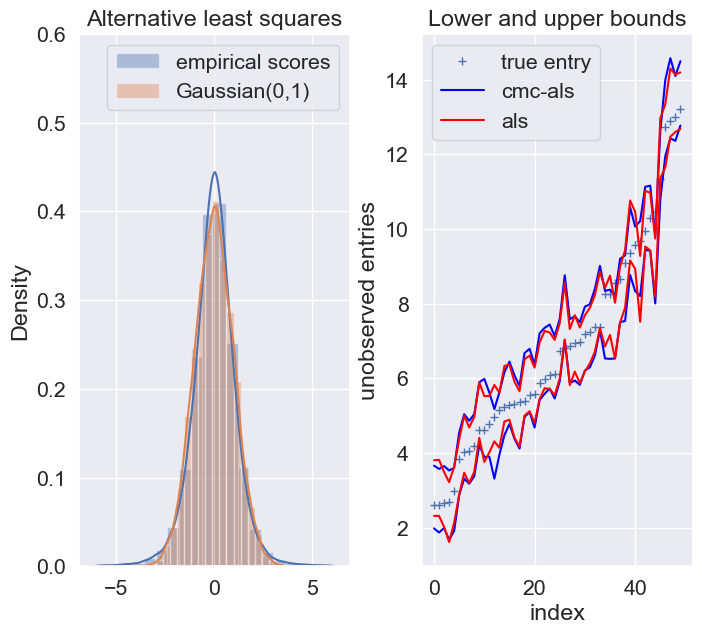

In [19]:
# plot
fig, ax = plt.subplots(ncols=2,figsize=(7,6))
fig.tight_layout(pad=0.6)
sns.set(font_scale = 1.4)

ind = np.random.choice(n0,50)
ind_seq = range(50)

sns.distplot(u_hat_als[np.abs(u_hat_als)<6], bins=20,kde=True, hist=True,label='empirical scores',ax=ax[0])
sns.distplot(u, bins=20,kde=True, hist=True,label='Gaussian(0,1)',ax=ax[0])
ax[0].legend(loc='best')
ax[0].set_title('Alternative least squares')
ax[0].set_ylim((0,0.6))

label1 = 'cmc-'+base1
label2 = 'cmc-'+base2
m_ = m_star[ind]
sort_ord = m_.argsort()
ind = ind[sort_ord]
# compare results with oracle and estimated P
ax[1].plot(ind_seq,m_star[ind],'b+',label='true entry')
ax[1].plot(ind_seq,lo_hat[ind],label=label2,c='blue')
ax[1].plot(ind_seq,up_hat[ind],c='blue')
ax[1].plot(ind_seq,lo_uq_als[ind],label=label4,c='red')
ax[1].plot(ind_seq,up_uq_als[ind],c='red')
ax[1].legend(loc='best')
ax[1].set_xlabel('index')
ax[1].set_ylabel('unobserved entries')
ax[1].set_title('Lower and upper bounds')

plt.savefig('../plots/sales_plot_'+het+'_'+str(rk)+'_'+str(alpha)+'.pdf', bbox_inches='tight')